In [1]:
# primitive
import sys
import os
import pickle
import itertools
from joblib import Parallel, delayed
from pprint import pprint
import itertools
from collections import Counter
from time import time

# data handling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# text
import MeCab
import spacy
import gensim
from gensim.models import KeyedVectors

# nn
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.vocab import Vocab

# **
# handmade libs
# *
src = '../../src'
if src not in sys.path: sys.path.append(src)

# constants
from const import *
constants = {k: v for k, v in locals().items() if k.isupper()}
pprint(constants)

# modules
from my_tokenizer import get_tokenizer
from livedoor_dataset import LivedoorDataset

/tmp/work/livedoor
{'DEVICE': 'cuda',
 'DIR_BIN': '/tmp/work/livedoor/bin',
 'DIR_DATA': '/tmp/work/livedoor/data',
 'DIR_LOG': '/tmp/work/livedoor/log',
 'DIR_MECAB_DIC': '/usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd',
 'DIR_MODEL': '/tmp/work/livedoor/model',
 'ROOT': '/tmp/work/livedoor',
 'SAMPLE_SENT': 'ワンマンライブに行きたい。',
 'TOKENIZER': 'mecab'}


Functions

In [2]:
ld_df = pd.read_csv(os.path.join(DIR_DATA, 'livedoor&text=text.csv'))

# 概観
print(ld_df.shape)
display(ld_df.head())
display(pd.DataFrame(ld_df.media.value_counts()).sort_index().T.style.background_gradient('Blues', axis=1))

(7366, 2)


,media,text
0,3,前回の「プロに聞く“合コンの極意”（前編） 合コンアナリスト水谷麻衣に聞く、合コンの勝ちパタ...
1,3,「3年で転職は早すぎる？」「将来が見えない」「仕事が面白くない」・・・若手社会人の悩みは尽き...
2,3,こんにちは、「ビズリーチ年収1000万円研究所」所長の佐藤和男です。この研究所では、年収10...
3,3,6月7日、表参道のカフェバー「MERCER CAFE TERRACE HOUSE」でHenn...
4,3,「3年で転職は早すぎる？」「将来が見えない」「仕事が面白くない」・・・若手社会人の悩みは尽き...


,0,1,2,3,4,5,6,7,8
media,870,870,863,511,870,842,770,900,870


Dataset

In [3]:
# get torch dataset
dataset = LivedoorDataset(ld_df)

# split dataset
TEST_RATE = 0.20
n = len(dataset)
n_test = int(np.floor(n * TEST_RATE))
n_train = int(n - n_test)
train_dataset, test_dataset = \
        random_split(dataset, [n_train, n_test], generator=torch.Generator().manual_seed(12345))

def show_dataset_label_balance(dataset):
    c = Counter([l for l, _ in dataset])
    df = pd.DataFrame(c.most_common()).set_index(0).sort_index().T
    display(df.style.background_gradient('Blues', axis=1))

show_dataset_label_balance(train_dataset)
show_dataset_label_balance(test_dataset)

0,0,1,2,3,4,5,6,7,8
1,698,687,690,392,675,688,632,732,699


0,0,1,2,3,4,5,6,7,8
1,172,183,173,119,195,154,138,168,171


Vocabulary

In [4]:
# Construct vocabulary; using only train and valid dataset
tokenizer = get_tokenizer('mecab')
print('output :', tokenizer(SAMPLE_SENT))

output : ['ワンマンライブ', 'に', '行き', 'たい', '。']


In [5]:
%%time
counter = Counter()
# logging
start = time()

for e, (label, text) in enumerate(train_dataset):
    counter.update(tokenizer(text))
    
    # logging
    if e!=0 and e%(1000)==0:
        current = time()
        interval = current-start
        print(f'| {(e):4d} samples done | {interval:5.2f} s |')
        start = current
        
vocab = Vocab(counter, min_freq=1)
PAD = vocab.stoi['<pad>']

# serialize
file_out = os.path.join(DIR_BIN, f'vocab_{TOKENIZER}.pkl') # 本当は dic で分けるべき
if not os.path.isfile(file_out):
    with open(file_out, 'wb') as f:
        pickle.dump(vocab, f)
    print(f'{file_out} : created')
else:
    print(f'{file_out} : file exists')

# test; 
print([vocab[str(token)] for token in tokenizer(SAMPLE_SENT)])

| 1000 samples done |  4.06 s |
| 2000 samples done |  1.13 s |
| 3000 samples done |  1.08 s |
| 4000 samples done |  1.07 s |
| 5000 samples done |  1.04 s |
/tmp/work/livedoor/bin/vocab_mecab.pkl : file exists
[38795, 5, 1283, 66, 4]
CPU times: user 6.67 s, sys: 115 ms, total: 6.79 s
Wall time: 9.59 s


# Experiments

Class, Functions

In [11]:
class RandomEmbedding(nn.Module):
    
    def __init__(self, vocab_size, embed_dim):
        super(RandomEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD)
        self.embedding.weight.requires_grad = False
    
    def forward(self, texts):
        return self.embedding(texts)

random_emb = RandomEmbedding(len(vocab), 300)
random_emb(torch.tensor([[2, 3, 4, 5, 6],
            [2, 3, 4, 1, 1],]))

tensor([[[ 1.4275, -0.2614,  1.2990,  ..., -0.4919, -0.8758, -0.3640],
         [ 1.6097,  0.9513, -0.0365,  ...,  1.9509,  0.1168,  0.3690],
         [-1.0105, -0.6849,  1.2189,  ...,  0.8843,  0.3979, -0.4137],
         [-0.4824, -0.8535, -0.9114,  ...,  1.0762,  0.1340, -0.0150],
         [ 0.6384, -0.1095, -0.5836,  ...,  0.4033,  0.1740, -2.3807]],

        [[ 1.4275, -0.2614,  1.2990,  ..., -0.4919, -0.8758, -0.3640],
         [ 1.6097,  0.9513, -0.0365,  ...,  1.9509,  0.1168,  0.3690],
         [-1.0105, -0.6849,  1.2189,  ...,  0.8843,  0.3979, -0.4137],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]])

In [13]:
class LSTMClassifier(nn.Module):
    
    def __init__(self, vocab_size, embed_dim, h_dim, class_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = RandomEmbedding(vocab_size, embed_dim)
#         self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD)
#         self.embedding.weight.requires_grad = False # ?
        self.lstm = nn.LSTM(embed_dim, h_dim, batch_first=True)
        self.linear = nn.Linear(h_dim, class_dim)
        
    def forward(self, texts):
        emb = self.embedding(texts)
        o, (h_n, c_n) = self.lstm(emb)
        out = self.linear(h_n)
        return out

lstm = LSTMClassifier(len(vocab), 300, 100, 9)
lstm(torch.tensor([[2, 3, 4, 5, 6],
            [2, 3, 4, 1, 1],]))

tensor([[[-0.1221,  0.0216, -0.0092, -0.0548,  0.2733, -0.1803,  0.1231,
          -0.0134,  0.2332],
         [-0.0432, -0.0265,  0.0323, -0.1438,  0.0343, -0.0684,  0.0097,
           0.0083,  0.0077]]], grad_fn=<AddBackward0>)

In [15]:
# tokenizer, label
text_pipeline = lambda text: [vocab.stoi[str(token)] for token in tokenizer(text)]

In [16]:
# train
def iter_train(dataloader, model, loss_fn, optimizer):
    current_size = 0
    current_loss, current_correct = 0, 0
    
    for batch, (labels, texts) in enumerate(dataloader):
        
        # indexing
        texts = [torch.tensor(text_pipeline(text)) for text in texts]
        texts = pad_sequence(texts, batch_first=True, padding_value=PAD)
            
        # send to GPU
        labels, texts = labels.to(DEVICE), texts.to(DEVICE)

        # pred
        pred = model(texts)[0]

        # get loss
        loss = loss_fn(pred, labels)

        # get gradient
        optimizer.zero_grad() # バッチごとに勾配をリセット
        loss.backward()

        # back propagate
        # 手動；todo: optimizer.step() の動作確認，デバッグ
        for layer_num, param in enumerate(model.parameters()):
            if layer_num==0:
                continue
            LR = optimizer.state_dict()['param_groups'][0]['lr']
            param.data -= LR * param.grad.data
#         optimizer.step()
        
        current_size += len(labels)
        current_loss += loss.item()
        current_correct += (pred.argmax(axis=1).squeeze()==labels).type(torch.int).sum().item()
        
        mean_loss = current_loss/current_size
        mean_correct = current_correct/current_size

        # logging
        if batch%30==0 and batch!=0:
            split = 'train'
            print(f'| {split*(1 if batch==0 else 0):5} | batch {batch:3d} '
                  f'| correct total: {mean_correct:0.8f} | loss total: {mean_loss:0.8f} |')
    
    return mean_correct, mean_loss

if DEVICE=='cuda':
    # 1 epoch sample execution
    sample_dataloader = DataLoader(train_dataset,
                                   batch_size=64,
                                   shuffle=False,)
    LR = 1e-4
    model = LSTMClassifier(len(vocab), 300, 100, 9).to(DEVICE)
    loss_fn = nn.CrossEntropyLoss().to(DEVICE)
    optimizer = torch.optim.SGD(model.parameters(), lr=LR)
    iter_train(sample_dataloader, model, loss_fn, optimizer)

|       | batch  30 | correct total: 0.11290323 | loss total: 0.03438054 |
|       | batch  60 | correct total: 0.11347336 | loss total: 0.03438617 |
|       | batch  90 | correct total: 0.12002060 | loss total: 0.03437196 |


In [17]:
# validate
def iter_test(dataloader, model, loss_fn):
    test_size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        # 全ての勾配計算を無効化
        for batch, (labels, texts) in enumerate(dataloader):
            
            # indexing
            texts = [torch.tensor(text_pipeline(text)) for text in texts]
            texts = pad_sequence(texts, batch_first=True, padding_value=PAD)
            
            # send to GPU
            labels, texts = labels.to(DEVICE), texts.to(DEVICE)
            
            # predict
            pred = model(texts)[0]

            # get loss
            test_loss += loss_fn(pred, labels).item()

            # eval
            pred_labels = pred.argmax(axis=1).squeeze() # この squeeze は問題ないのか？
            correct += (pred_labels==labels).type(torch.int).sum().item()

    correct /= test_size # Epoch 終了時点の Accuracy（正答数 / テストサンプルサイズ）
    test_loss /= test_size # Epoch 終了時点の 1 サンプルあたり Loss 平均（Loss / テストサンプルサイズ）

    split = 'test'
    print(f'| {split:5} | accuracy: {correct:0.4f} | loss avg: {test_loss:6.8f} |', end='')
    
    return correct, test_loss

if DEVICE=='cuda':
    # sample execution
    sample_dataloader = DataLoader(test_dataset,
                                   batch_size=64,
                                   shuffle=False,)
    LR = 1e-2
    model = LSTMClassifier(len(vocab), 300, 100, 9).to(DEVICE)
    loss_fn = nn.CrossEntropyLoss().to(DEVICE)
    optimizer = torch.optim.SGD(model.parameters(), lr=LR)
    iter_test(sample_dataloader, model, loss_fn)

| test  | accuracy: 0.1161 | loss avg: 0.03601903 |

Execute

In [20]:
# model setting
model_name = 'lstm'
embed_type = 'random'
embed_dim = 300
hidden_dim = 100

# training setting
batchsizes = [128]
lrs = [1e-1]
mos = [0.9]
n_epochss = [1]

for (batchsize, lr, mo, n_epochs) in itertools.product(batchsizes, lrs, mos, n_epochss):
    # dataloader
    train_dataloader = DataLoader(train_dataset,
                                  batch_size=batchsize,
                                  shuffle=False,)

    test_dataloader = DataLoader(test_dataset,
                                  batch_size=batchsize,
                                  shuffle=False,)

    # modules
    loss_fn = nn.CrossEntropyLoss().to(DEVICE)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=mo)

    # define network architecture
    model = LSTMClassifier(len(vocab), embed_dim, hidden_dim, 9).to(DEVICE)

    # train model
    result = []
    start = time()
    for epoch in range(n_epochs):

        print(f'{"-"*28} Epoch {epoch} {"-"*28}')
        train_acc, train_loss = iter_train(train_dataloader, model, loss_fn, optimizer)
        test_acc, test_loss = iter_test(test_dataloader, model, loss_fn)
        print(f' {time()-start:5.2f} sec |')
        result.append((epoch, train_acc, train_loss, test_acc, test_loss))

    print('done!')
    
    # **
    # save
    # *
    filename_base = f'emb={embed_type}&edim={embed_dim:03d}&model={model_name}&hdim={hidden_dim:03d}&batchsize={batchsize:03d}&optim=sgd&lr={lr:.5f}&mo={mo:.1f}&epochs={n_epochs:d}'
    filename_model = os.path.join(DIR_MODEL, filename_base+'.pth')
    filename_log = os.path.join(DIR_LOG, filename_base+'.csv')

    # save model
    if not os.path.isfile(filename_model):
        torch.save(model, filename_model)
        print(f'{filename_model} : created')
    else:
        print(f'{filename_model} : exists')

    # save log
    if not os.path.isfile(filename_log):
        result = pd.DataFrame(result).rename(columns={0: 'epoch',
                                                      1: 'train_acc',
                                                      2: 'train_loss',
                                                      3: 'test_acc',
                                                      4: 'test_loss'})
        result.to_csv(filename_log, index=False)
        print(f'{filename_log} : created')
    else:
        print(f'{filename_log} : exists')

---------------------------- Epoch 0 ----------------------------
|       | batch  30 | correct total: 0.10786290 | loss total: 0.01718809 |
| test  | accuracy: 0.1181 | loss avg: 0.01808906 | 30.44 sec |
done!
/tmp/work/livedoor/model/emb=random&edim=300&model=lstm&hdim=100&batchsize=128&optim=sgd&lr=0.10000&mo=0.9&epochs=1.pth : created
/tmp/work/livedoor/log/emb=random&edim=300&model=lstm&hdim=100&batchsize=128&optim=sgd&lr=0.10000&mo=0.9&epochs=1.csv : created


# Evaluation

CPU times: user 3.56 s, sys: 744 ms, total: 4.31 s
Wall time: 4.06 s


<AxesSubplot:xlabel='col_0', ylabel='row_0'>

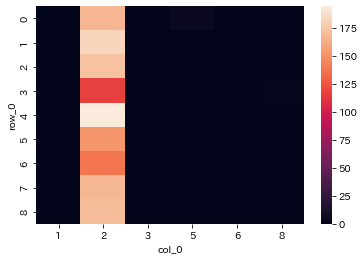

In [23]:
%%time
def predict_dataloader(dataloader, model):
    test_size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    all_labels = []
    
    with torch.no_grad():
        # 全ての勾配計算を無効化
        for batch, (labels, texts) in enumerate(dataloader):
            
            all_labels.append(list(labels.numpy()))
            
            # indexing
            texts = [torch.tensor(text_pipeline(text)) for text in texts]
            texts = pad_sequence(texts, batch_first=True, padding_value=PAD)
            
            # send to GPU
            labels, texts = labels.to(DEVICE), texts.to(DEVICE)
            
            # predict
            pred = model(texts)[0]
            pred = pred.cpu().numpy()
            if batch==0:
                pred_all = pred
            else:
                pred_all = np.append(pred_all, pred, axis=0)
    
    return np.array(list(itertools.chain.from_iterable(all_labels))), pred_all.argmax(axis=1)

model = torch.load(os.path.join(DIR_MODEL, 'lstm&batchsize=128&lr=0.00003&mo=0.9&epochs=100.pth'))
all_labels, pred = predict_dataloader(test_dataloader, model)
sns.heatmap(pd.crosstab(all_labels, pred))

# Primitive model

create feature dataset

In [26]:
def get_embedding_table(dataloader):
    X, y = [], []
    for batch, (labels, texts) in enumerate(dataloader):
        texts = [torch.tensor(text_pipeline(text)) for text in texts]
        texts = pad_sequence(texts, batch_first=True, padding_value=PAD)
        labels, texts = labels.to(DEVICE), texts.to(DEVICE)
        emb = model.embedding(texts).detach().cpu().numpy().mean(axis=1)
        X.append(emb)
        y.append(labels.detach().cpu().numpy())
    
    X = np.array(list(itertools.chain.from_iterable(X)))
    y = np.array(list(itertools.chain.from_iterable(y)))
        
    return X, y

model = LSTMClassifier(len(vocab), 300, 100, 9).to(DEVICE)
X_train, y_train = get_embedding_table(train_dataloader)
X_test, y_test = get_embedding_table(test_dataloader)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5893, 300) (5893,)
(1473, 300) (1473,)


feature overview

(9, 300)


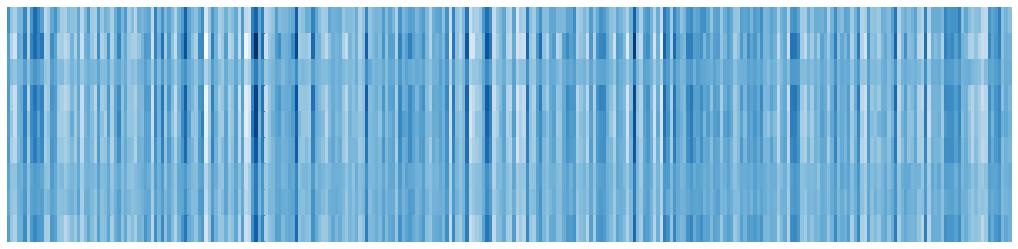

In [27]:
%matplotlib inline

def show(embedding):
    w = 18
    h = embedding.shape[0] * (w / 300) * 8

    fig = plt.figure(figsize=(w, h))
    ax = fig.add_subplot(1, 1, 1)

    print(embedding.shape)
    sns.heatmap(pd.DataFrame(embedding), cbar=False, xticklabels=False, yticklabels=False, cmap='Blues')

    plt.show()
    return

df = pd.DataFrame(X_train)
show(df.groupby(y_train).mean())

ベンチマーク；SVM で 82 %

In [28]:
from sklearn.svm import SVC

model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

sum(y_pred == y_test) / len(y_test)

0.8268839103869654

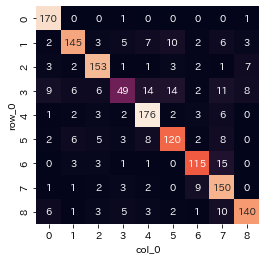

In [29]:
%matplotlib inline

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
sns.heatmap(pd.crosstab(y_test, y_pred), cbar=False, annot=True, fmt='d')
plt.show()

# Work

In [17]:
%%time
# embed
wv = KeyedVectors.load_word2vec_format('/data/chive/chive-1.2-mc5/chive-1.2-mc5.txt')
wv

CPU times: user 14min 50s, sys: 14.3 s, total: 15min 4s
Wall time: 15min 4s
